# 3. Linear Models for Regression

In [91]:
import torch
torch.__version__

'1.3.0.dev20190812'

In [92]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1234)

In [93]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

## 3.1 Linear Basis Function Models

In [94]:
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import norm

In [159]:
def guassian_transform(x, means, std):
    X = np.zeros((len(x), len(means)))
    for i, mean in enumerate(means):
        X[:, i] = norm(mean, std).pdf(x)
    return X

def sigmoid_transform(x, means, coef):
    X = np.zeros((len(x), len(means)))
    for i, mean in enumerate(means):
        X[:, i] = np.tanh((x - mean) * coef * 0.5) * 0.5 + 0.5
    return X

In [96]:
x = np.linspace(-1, 1, 100)
num_features = 11
means = np.linspace(-1, 1, num_features)
X_polynomial = PolynomialFeatures(num_features).fit_transform(x[:, None])
X_gaussian = guassian_transform(x, means, std=0.1);
X_sigmoid = sigmoid_transform(x, means, coef=10)

(100, 12)
(100, 11)
(100, 11)


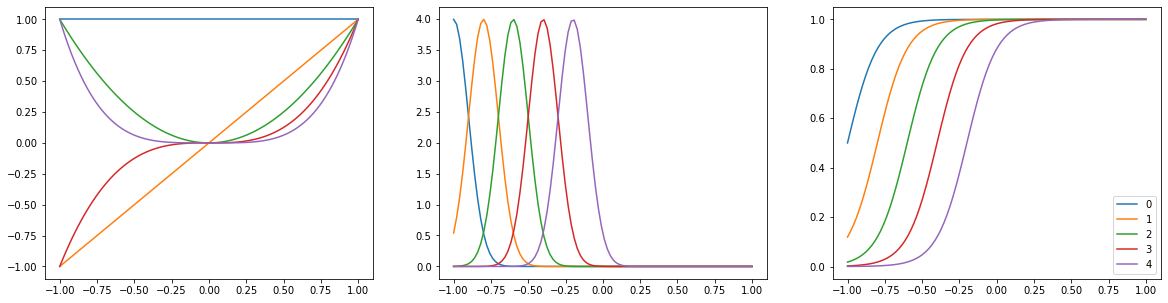

In [97]:
plt.figure(figsize=(20, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoid]):
    print(X.shape)
    plt.subplot(1, 3, i + 1)
    for j in range(5):
        plt.plot(x, X[:, j], label=f"{j}")
plt.legend()

### 3.1.1 Maximum likelihood and least squares

In [98]:
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [100]:
# Pick one of the three features below
num_features = 11
means = np.linspace(0, 1, num_features)
poly = PolynomialFeatures(num_features)
X_train = poly.fit_transform(x_train[:,None])
X_test = poly.fit_transform(x_test[:,None])

# X_train = guassian_transform(x_train, means, std=0.1)
# X_test = guassian_transform(x_test, means, std=0.1)

# X_train = sigmoid_transform(x_train, means=np.linspace(0, 1, 8), coef=10)
model = LinearRegression()
model.fit(X_train, y_train)
y = model.predict(X_test)
y_std = y.std()

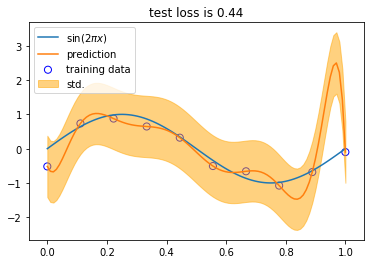

In [101]:
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y, label="prediction")
plt.fill_between(
    x_test, y - y_std, y + y_std,
    color="orange", alpha=0.5, label="std.")
plt.title(f"test loss is {mean_squared_error(y, y_test):.2f}")
plt.legend()
plt.show()

### 3.1.4 Regularized least squares and Gaussian prior
Let us assume that the outputs are linearly related to the inputs via $\beta$ and that the data are corrupted by some noise $\epsilon$:
$$y_{n}=\beta x_{n}+\epsilon$$
where $\beta$ is Gaussian noise with mean $0$ and variance $\sigma^2$. The likelihood is 
$$\prod_{n=1}^{N} \mathcal{N}\left(y_{n} | \beta x_{n}, \sigma^{2}\right),$$
suppose $\beta$ is Gaussian $\mathcal{N}\left(\beta | 0, \lambda^{-1}\right)$, where $\lambda > 0$. Then we get
$$\prod_{n=1}^{N} \mathcal{N}\left(y_{n} | \beta x_{n}, \sigma^{2}\right) \mathcal{N}\left(\beta | 0, \lambda^{-1}\right).$$

$\lambda^{-1}=\sigma_\beta^2$. If $\lambda\to 0$, then $\beta$ will have so much space to learn. Otherwise if $\lambda\to\infty$, then $\beta$ will be constant. We take the logarithm of this formula and drop the constant
\begin{align*}
\arg\max_\beta \log(\beta|x,y) &= \arg\max_\beta \log(x,y|\beta)+\log(\beta) \\
&=\arg\max_\beta -\frac{N}{2} \ln (2 \pi)-\frac{N}{2} \ln \left(\sigma^{2}\right)-\frac{1}{2 \sigma^{2}} \sum_{j=1}^{N}\left(y_{j}-\beta x_j\right)^{2} -\frac{N}{2} \ln (2 \pi)-\frac{N}{2} \ln \left(\lambda^{-1}\right)-\frac{\lambda}{2} \sum_{j=1}^{N}\left(\beta-0\right)^{2}\\
&=\arg\max_\beta -\frac{1}{2 \sigma^{2}} \sum_{j=1}^{N}\left(y_{j}-\beta x_j\right)^{2}-\frac{\lambda N \beta^2}{2}+ \text{const}
\end{align*}

which is just L2 regularization
$$\min \left(\|\mathrm{Y}-\mathrm{X}(\beta)\|_{2}^{2}+\lambda\|\beta\|_{2}^{2}\right)$$

In [102]:
from sklearn.linear_model import Ridge

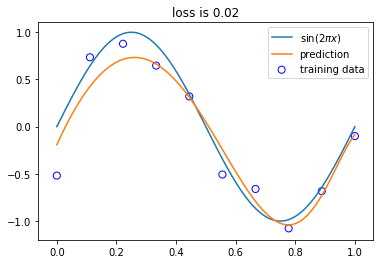

In [103]:
model = Ridge(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y, label="prediction")
plt.title(f"loss is {mean_squared_error(y, y_test):.2f}")
plt.legend()
plt.show()

### 3.1.5 L1 regularization and Laplacian prior
The Laplace distribution is
$$\text {Laplace}(\mu, b)=\frac{1}{2 b} e^{-\frac{|x-\mu|}{b}}$$

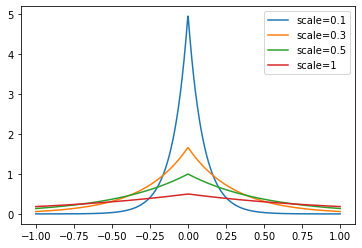

In [104]:
from scipy.stats import laplace

x = np.linspace(-1, 1, 1000)
for scale in [0.1, 0.3, 0.5, 1]:
    y = laplace.pdf(x, loc=0, scale=scale)
    plt.plot(x, y, label=f"scale={scale}")
plt.legend()

Laplacian prior $\beta \sim \text { Laplace }(0, b)$,
\begin{align*}
    \arg \max _{\beta} -\frac{1}{2 \sigma^{2}} \sum_{j=1}^{N}\left(y_{j}-\beta x_{j}\right)^{2} + \log \prod_{j=0}^{N} \frac{1}{2 b} e^{-\frac{\left|\beta_{j}\right|}{2 b}} &= \arg \max _{\beta}-\frac{1}{2 \sigma^{2}} \sum_{j=1}^{N}\left(y_{j}-\beta x_{j}\right)^{2}+ \sum_{j=1}^{N} \left(-\log 2b -\frac{\left|\beta_{j}\right|}{2 b}\right)\\
        &=\arg \min_{\beta}\frac{1}{2 \sigma^{2}} \sum_{j=1}^{N}\left(y_{j}-\beta x_{j}\right)^{2}+ \sum_{j=1}^{N} \left(\log 2b +\frac{\left|\beta_{j}\right|}{2 b}\right)\\
        &=\arg \min _{\beta}  \sum_{j=1}^{N}\left(y_{j}-\beta x_{j}\right)^{2}+\lambda\sum_{j=1}^{N}\left|\beta_{j}\right|
\end{align*}

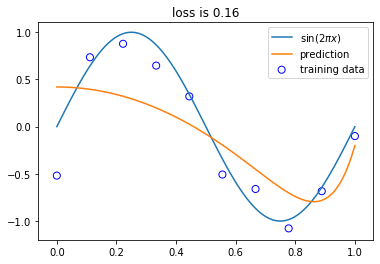

In [105]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=1e-2)
model.fit(X_train, y_train)
y = model.predict(X_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y, label="prediction")
plt.title(f"loss is {mean_squared_error(y, y_test):.2f}")
plt.legend()

In [106]:
model.coef_

array([ 0.        ,  0.        , -1.99762739, -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.37781459])

The Lasso regression will zeroing out many coefficient but ridge will only shrink each coefficient
$$\beta_0=\|(1,0)\|_{1}=1<\left\|\left(\frac{1}{\sqrt{2}}, \frac{1}{\sqrt{2}}\right)\right\|_{1}=\sqrt{2}<\beta_1$$

## 3.2 The Bias-Variance Decomposition
Let $f(x)$ be the real function and $\hat{f}(x)$ be the learned function, the error rate is
\begin{aligned}
\operatorname{Err}(x) &=(E[\hat{f}(x)]-f(x))^{2}+E\left[(\hat{f}(x)-E[\hat{f}(x)])^{2}\right]+\sigma_{e}^{2}\\
                      &=\text { Bias }^{2}+\text { Variance }+\text { Irreducible Error }
\end{aligned}

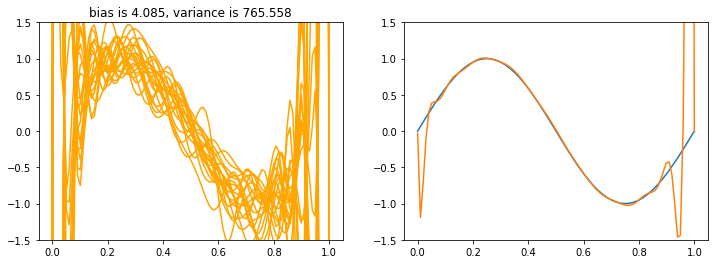

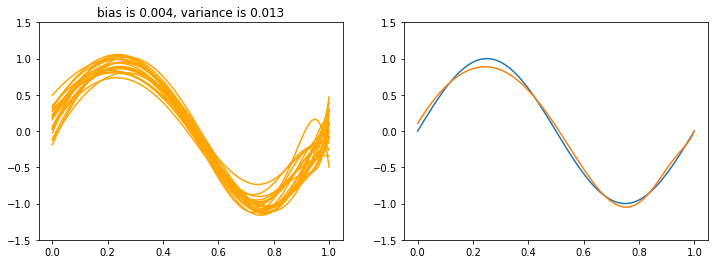

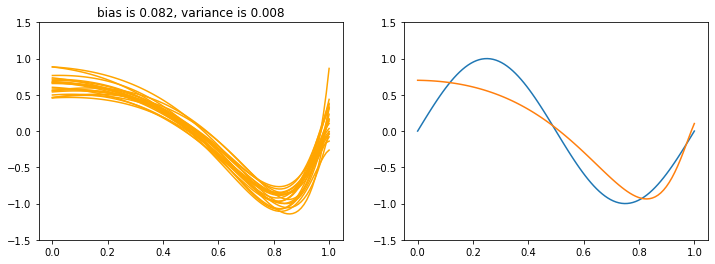

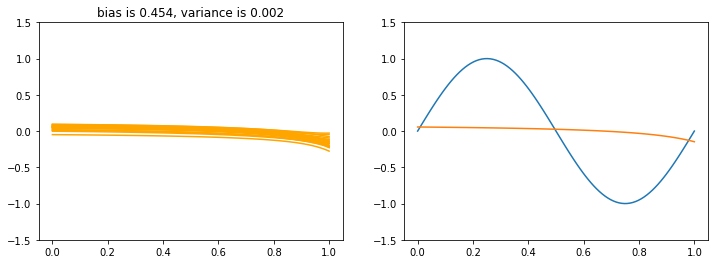

In [107]:
means = np.linspace(0, 1, 24)
feature = PolynomialFeatures(24)
# feature = GaussianFeature(np.linspace(0, 1, 24), 0.1)
# feature = SigmoidalFeature(np.linspace(0, 1, 24), 10)
for alpha in [0, 1e-3, 1e-1, 100]:
    y_list = []
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(100):
        x_train, y_train = create_toy_data(sinusoidal, sample_size=25, std=0.25)
        X_train = feature.fit_transform(x_train[:, None])
        X_test = feature.fit_transform(x_test[:, None])
        model = Ridge(alpha)
        model.fit(X_train, y_train)
        y = model.predict(X_test)
        y_list.append(y)
        if i < 20: plt.plot(x_test, y, c="orange")
    plt.ylim(-1.5, 1.5)
    
    y_list = np.array(y_list)
    y_mean = y_list.mean(axis=0)
    plt.title(f"bias is {np.mean(np.square(y_mean-y_test)):.3f}, variance is {np.mean(np.square(y_list-y_mean)):.3f}")
    plt.subplot(1, 2, 2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, y_mean)
    plt.ylim(-1.5, 1.5)
    plt.show()

## 3.3 Bayesian Linear Regression

BayesianRidge estimates a probabilistic model of the regression problem as described above. The prior for the coefficient $w$ is given by a spherical Gaussian:
\begin{align*}
p(w | \lambda)&=\mathcal{N}\left(w | 0, \lambda^{-1} \mathbf{I}_{p}\right)\\
p(y | X, w, \alpha)&=\mathcal{N}(y | X w, \alpha)
\end{align*}
The priors over $\lambda$  and  $\alpha$ are chosen to be gamma distributions.

### 3.3.1 Parameter distribution

In [146]:
from sklearn.linear_model import BayesianRidge

In [147]:
def linear(x):
    return -0.3 + 0.5 * x

x_train, y_train = create_toy_data(linear, 100, 0.1, [-1, 1])
x = np.linspace(-1, 1, 100)
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)
print(w.shape)

(100, 100, 2)


(100, 2)
[0.         0.02199421] -0.19811625369300365
101.48092147120535 69.06310624708443


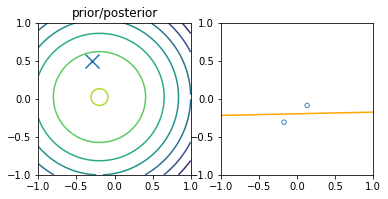

[ 0.         -0.00961359] -0.21816708514474611
100.33733044235305 298.1924152829764


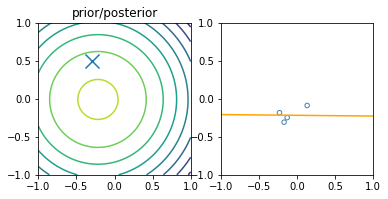

[0.         0.07069969] -0.3080698824417794
107.94361562091599 13.825349490212174


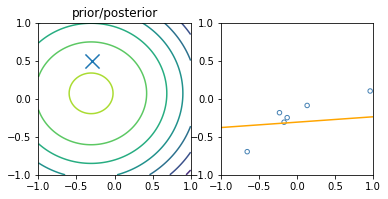

[0.         0.01468868] -0.1396701063452481
101.93564041936506 52.79701395614625


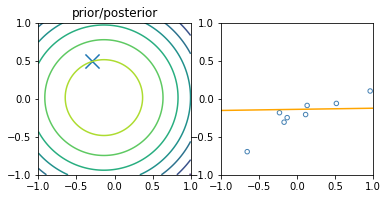

[0.        0.2060902] -0.2640450966001578
17.35683283006863 4.408018022049452


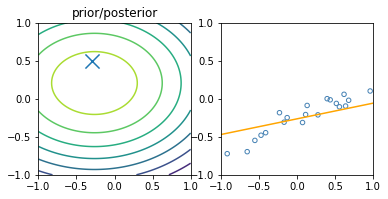

[0.         0.48444637] -0.30117513784920674
2.5399150677422857 2.319897154383465


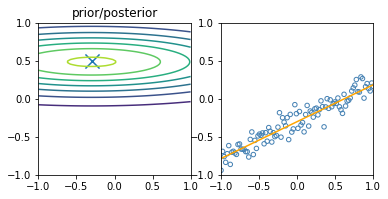

In [158]:
feature = PolynomialFeatures(degree=1)
X_train = feature.fit_transform(x_train[:,None])
X = feature.fit_transform(x[:,None])
print(X.shape)
model = BayesianRidge(lambda_2=1., alpha_2=100.)
for begin, end in [[0, 2], [2, 4], [4, 6], [6, 8], [8, 20], [20, 100]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    plt.subplot(1, 2, 1)
    plt.scatter(-0.3, 0.5, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean=[model.intercept_, model.coef_[1]], cov=model.sigma_))
    plt.gca().set_aspect('equal')
    plt.title("prior/posterior")
    print(model.coef_, model.intercept_)
    print(1/model.alpha_, 1/model.lambda_)
    
    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:end], y_train[:end], s=20, facecolor="none", edgecolor="steelblue", lw=1)
    plt.plot(x, model.predict(X), c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### 3.3.2 Predictive distribution

In [162]:
x_train, y_train = create_toy_data(sinusoidal, 100, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

mean, std = np.linspace(0, 1, 9), 0.1
X_train = guassian_transform(x_train, mean, std)
X_test = guassian_transform(x_test, mean, std)

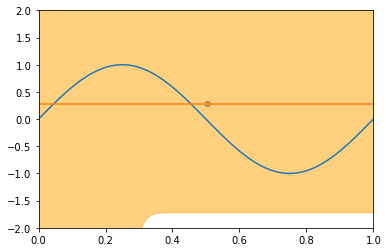

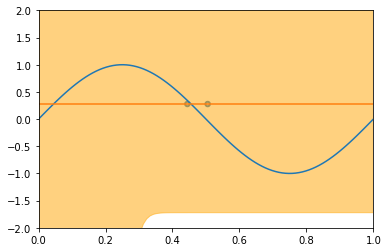

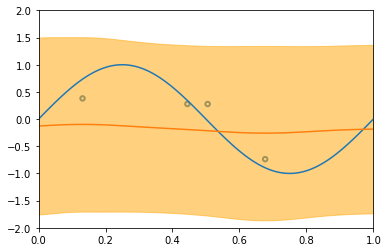

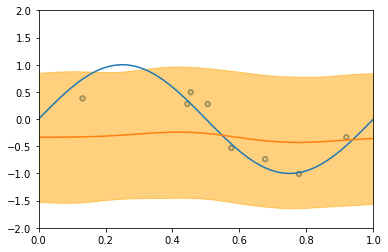

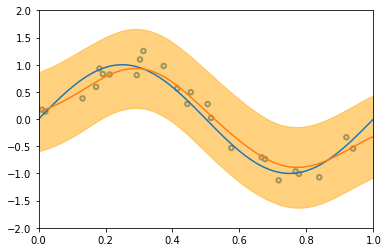

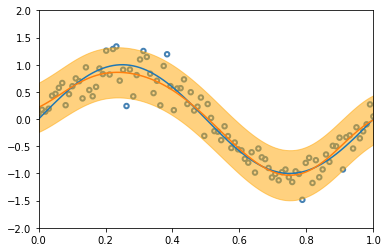

In [164]:
model = BayesianRidge(lambda_2=1e-3, alpha_2=2.)
for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25], [25, 100]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    y, y_std = model.predict(X_test, return_std=True)
    plt.scatter(x_train[:end], y_train[:end], s=20, facecolor="none", edgecolor="steelblue", lw=2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, y)
    plt.fill_between(x_test, y - y_std, y + y_std, color="orange", alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.show()

## 3.5 The Evidence Approximation

In [ ]:
def cubic(x):
    return x * (x - 5) * (x + 5)

x_train, y_train = create_toy_data(cubic, 30, 10, [-5, 5])
x_test = np.linspace(-5, 5, 100)
evidences = []
models = []
for i in range(8):
    feature = PolynomialFeatures(degree=i)
    X_train = feature.fit_transform(x_train)
    model = EmpiricalBayesRegression(alpha=100., beta=100.)
    model.fit(X_train, y_train, max_iter=100)
    evidences.append(model.log_evidence(X_train, y_train))
    models.append(model)

degree = np.nanargmax(evidences)
regression = models[degree]

X_test = PolynomialFeature(degree=int(degree)).transform(x_test)
y, y_std = regression.predict(X_test, return_std=True)

plt.scatter(x_train, y_train, s=50, facecolor="none", edgecolor="steelblue", label="observation")
plt.plot(x_test, cubic(x_test), label="x(x-5)(x+5)")
plt.plot(x_test, y, label="prediction")
plt.fill_between(x_test, y - y_std, y + y_std, alpha=0.5, label="std", color="orange")
plt.legend()
plt.show()

plt.plot(evidences)
plt.title("Model evidence")
plt.xlabel("degree")
plt.ylabel("log evidence")
plt.show()